In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config
from tyssue.topology.sheet_topology import cell_division

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model

from tyssue.core.generation import extrude
from tyssue.core.monolayer import Monolayer, MonolayerWithLamina
from tyssue.geometry.bulk_geometry import BulkGeometry, MonoLayerGeometry
from tyssue.dynamics.bulk_model import BulkModel, LaminaModel, set_model
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view, quick_edge_draw

from tyssue.topology.sheet_topology import remove_face
from tyssue.core.objects import get_opposite
from tyssue.io.hdf5 import save_datasets, load_datasets

from tyssue.topology.monolayer_topology import cell_division

In [2]:
import vispy

In [3]:
vispy.__version__

'0.5.0.dev0'

In [8]:
datasets = load_datasets('../data/hf5/small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()


# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12,},
    'face': {
        'contractility': 0.04,
        'prefered_area': 0.6,
        'area_elasticity': 1.},
    'cell': {
        'prefered_vol': 1.0,
        'vol_elasticity': 0.5},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.05,
            'prefered_area': 0.5,
            'area_elasticity': 0.5}
    },
    'basal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.1,
            'prefered_area': 0.2}},
    }

set_model(monolayer, BulkModel, apical_spec, modifiers)
res = Solver.find_energy_min(monolayer, BulkGeometry, BulkModel)





In [9]:
def two_panels(monolayer):

    fig, (xy, zy) = plt.subplots(1, 2, sharey=True)
    fig, xy = quick_edge_draw(monolayer, coords=['x', 'y'], ax=xy, c='k', alpha=0.3)
    fig, zy = quick_edge_draw(monolayer, coords=['z', 'y'], ax=zy, c='k', alpha=0.3)
    fig.set_size_inches(12, 6)
    return fig

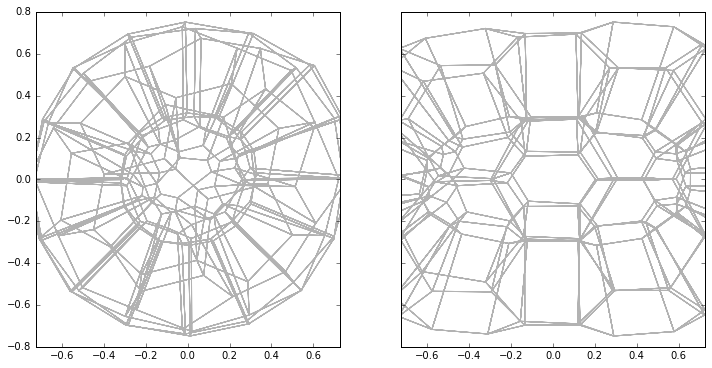

In [10]:
fig = two_panels(monolayer)

In [11]:
mother = 10
daughter = cell_division(monolayer, mother, orientation='vertical')


In [12]:
mother_faces = set(
    monolayer.edge_df[monolayer.edge_df['cell'] == mother]['face'])

monolayer.face_df['visible'] = 0
monolayer.face_df.loc[mother_faces, 'visible'] = 1

res = Solver.find_energy_min(monolayer, BulkGeometry, BulkModel)
draw_specs = config.draw.sheet_spec()
draw_specs['face']['visible'] = True
# 


In [13]:
from tyssue.io import obj

In [14]:
obj.save_junction_mesh('ellipsoid.obj', monolayer)

                be advised the file cannot be read back in vispy


This is buggy in some vispy installations ATM
```
canvas, view = vp_view(monolayer, **draw_specs)
img = canvas.render()
fig, ax = plt.subplots()
ax.imshow(img)
```

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


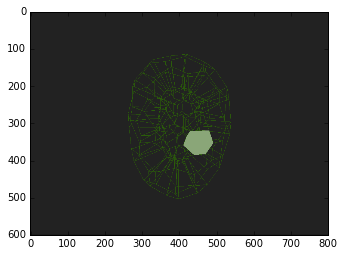

In [15]:
canvas, view = vp_view(monolayer, **draw_specs)
img = canvas.render()
fig, ax = plt.subplots()
ax.imshow(img)

In [39]:
monolayer.cell_df.head()

,x,y,z,is_alive,vol,num_faces,prefered_vol,vol_elasticity
cell,,,,,,,,
0,0.684271,0.063878,-0.771568,1.0,0.146522,7,1.0,0.5
1,0.699637,0.264098,-0.409970,1.0,0.142592,8,1.0,0.5
2,0.722911,0.006801,0.019899,1.0,0.190427,8,1.0,0.5
3,0.635004,0.265988,0.480347,1.0,0.185586,8,1.0,0.5
4,0.583775,-0.018901,0.880647,1.0,0.170147,8,1.0,0.5


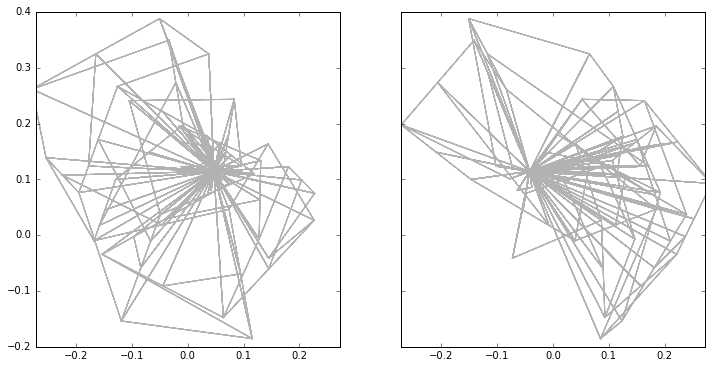

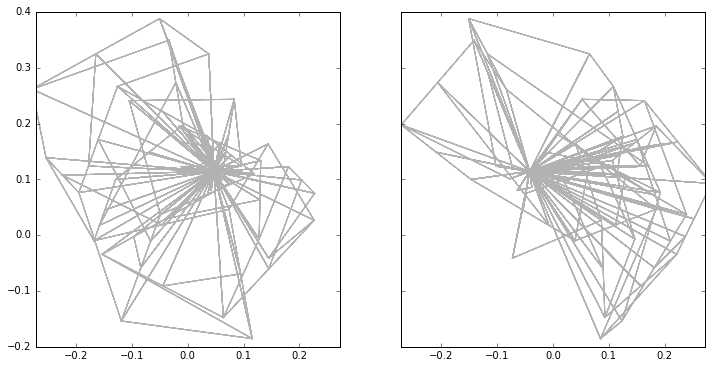

In [16]:
for cell in monolayer.cell_df.index:
    try:
        daughter = cell_division(monolayer, cell,
                                 orientation='vertical')
        res = Solver.find_energy_min(monolayer, BulkGeometry, BulkModel)
    except ValueError as e:
        print('Failed for cell {}'.format(cell))
        continue

monolayer.sanitize()
monolayer.reset_index()
monolayer.reset_topo()
two_panels(monolayer)

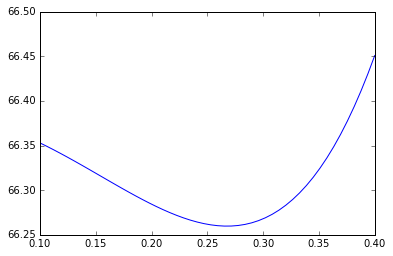

In [14]:
scales = np.linspace(0.1, 0.4)
pref_areas = scales**2
energies= np.zeros(scales.size)

for i, s in enumerate(pref_areas):
    
    #MonoLayerGeometry.scale(monolayer, s, coords=monolayer.coords)
    #MonoLayerGeometry.update_all(monolayer)
    monolayer.cell_df['prefered_vol'] *= s
    energies[i] = BulkModel.compute_energy(monolayer)
    #MonoLayerGeometry.scale(monolayer, 1/s, coords=monolayer.coords)
    #MonoLayerGeometry.update_all(monolayer)
    monolayer.cell_df['prefered_vol'] *= 1/s
fig, ax = plt.subplots()
ax.plot(scales, energies)

In [16]:
monolayer.face_df['prefered_area'] *= pref_areas[np.argmin(energies)]
monolayer.cell_df['prefered_vol'] *= scales[np.argmin(energies)]


In [17]:
opt = scales[np.argmin(energies)]
MonoLayerGeometry.scale(monolayer, opt, coords=monolayer.coords)
MonoLayerGeometry.update_all(monolayer)

In [18]:
Solver.find_energy_min(monolayer, MonoLayerGeometry, BulkModel)

      fun: 2.032030563000891
 hess_inv: <1152x1152 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.10384023,  0.2696162 ,  0.06750965, ...,  0.06423383,
       -0.05392283,  0.02542653])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 929
      nit: 927
   status: 0
  success: True
        x: array([-0.00026091,  0.00255134, -0.00541535, ..., -0.0002607 ,
        0.00255124, -0.00541533])

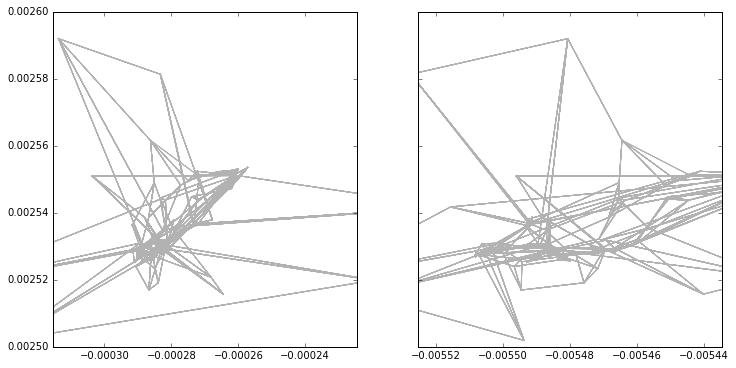

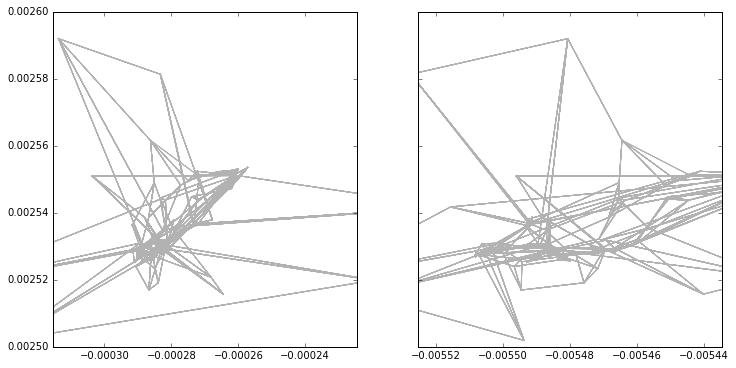

In [19]:
two_panels(monolayer)

In [22]:
from tyssue.io import obj

In [43]:
obj.save_junction_mesh('../data/obj/crashed.obj', monolayer)

                be advised the file cannot be read back in vispy


In [40]:
monolayer.face_df.loc[monolayer.sagittal_faces, 'prefered_area'] /= 2